## New Topics:
- Normalization using mean and standard deviation
- Crop and padding augmentation
- Multiple augmentation technique in datagen.flow
- Parameters adjustment using trackbars
- Model with lambda layer
- One cycle LR

### Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Colab Notebooks/EVA - Assignments/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/EVA - Assignments


### Import Modules and Dependencies

In [2]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(2019) 

from keras import regularizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv2D, MaxPooling2D,AveragePooling2D, Convolution2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, SpatialDropout2D, GlobalMaxPooling2D, Input, add, concatenate, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import cv2
from google.colab.patches import cv2_imshow

import imgaug as ia
import imgaug.augmenters as iaa

Using TensorFlow backend.


### Import Data

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 9s 0us/step


### Print Data Dimensions

In [4]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


### Display Data Samples

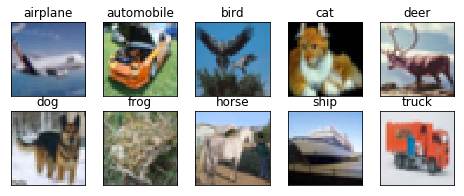

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Data Normalization

In [6]:
# Convert data in the range 0&1
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# Findout mean and standard deviation
train_mean = np.mean(train_features, axis=(0,1,2))
train_std = np.std(train_features, axis=(0,1,2))
print("Mean: ", train_mean, "\t Std Deviation: ", train_std)

# Normalize the data
train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

# One Hot Encoding
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Mean:  [0.4914009  0.48215896 0.4465308 ] 	 Std Deviation:  [0.24703279 0.24348423 0.26158753]


### Training Plots

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Cutout, Crop and Padding

In [0]:
cap = iaa.CropAndPad(percent=(-0.05, 0.2), pad_mode=ia.ALL, pad_cval=(0, 255))

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c
        
        # Crop and Padding 
        input_img = cap.augment_image(input_img)

        return input_img
      
    return eraser

### Model Architecture

In [10]:
input = Input(shape=(32, 32, 3,))

layer1 = Conv2D(64, (3,3), kernel_initializer='glorot_uniform', padding='same', use_bias=False)(input)
layer1 = BatchNormalization(momentum=0.99, epsilon=0.001)(layer1)
layer1 = Activation('relu')(layer1)

layer2 = Conv2D(64, (3,3), kernel_initializer='glorot_uniform', padding='same', use_bias=False)(layer1)
layer2 = BatchNormalization(momentum=0.99, epsilon=0.001)(layer2)
layer2 = Activation('relu')(layer2)

MP1 = MaxPooling2D(2)(layer2)

layer2_1 = Conv2D(128, (3,3), kernel_initializer='glorot_uniform', padding='same', use_bias=False)(MP1)
layer2_1 = BatchNormalization(momentum=0.99, epsilon=0.001)(layer2_1)
layer2_1 = Activation('relu')(layer2_1)

layer2_2 = Conv2D(128, (3,3), kernel_initializer='glorot_uniform', padding='same', use_bias=False)(layer2_1)
layer2_2 = BatchNormalization(momentum=0.99, epsilon=0.001)(layer2_2)
layer2_2 = Activation('relu')(layer2_2)

# Concat
block2_out = concatenate([layer2_2, MP1])

layer3 = Conv2D(128, (3,3), kernel_initializer='glorot_uniform', padding='same', use_bias=False)(block2_out)
layer3 = BatchNormalization(momentum=0.99, epsilon=0.001)(layer3)
layer3 = Activation('relu')(layer3)
MP2 = MaxPooling2D(2)(layer3)

layer4 = Conv2D(64, (3,3), kernel_initializer='glorot_uniform', padding='same', use_bias=False)(MP2)
layer4 = BatchNormalization(momentum=0.99, epsilon=0.001)(layer4)
layer4 = Activation('relu')(layer4)
MP3 = MaxPooling2D(2)(layer4)

layer4_1 = Conv2D(256, (3,3), kernel_initializer='glorot_uniform', padding='same', use_bias=False)(MP3)
layer4_1 = BatchNormalization(momentum=0.99, epsilon=0.001)(layer4_1)
layer4_1 = Activation('relu')(layer4_1)

layer4_2 = Conv2D(256, (3,3), kernel_initializer='glorot_uniform', padding='same', use_bias=False)(layer4_1)
layer4_2 = BatchNormalization(momentum=0.99, epsilon=0.001)(layer4_2)
layer4_2 = Activation('relu')(layer4_2)

# Concat
block4_out = concatenate([layer4_2, MP3])

# globalmaxpool
GMP = GlobalMaxPooling2D()(block4_out)

DenseLayer = Dense(num_classes, kernel_initializer='glorot_uniform', use_bias=False)(GMP)

Scaling = Lambda(lambda x: x*0.125)(DenseLayer)

model = Model(inputs=[input], outputs=[Scaling])
# model.summary()

W0724 18:10:02.283679 139966665582464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 18:10:02.315551 139966665582464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 18:10:02.325874 139966665582464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 18:10:02.357913 139966665582464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0724 18:10:02.358748 1399666655

### Hyperparameters

In [0]:
BATCH_SIZE = 128        #@param ["512", "256", "128"] {type:"raw"}
MOMENTUM = 0.9          #@param ["0.9", "0.95", "0.975"] {type:"raw"}
WEIGHT_DECAY = 0.000125 #@param ["0.000125", "0.00025", "0.0005"] {type:"raw"}
LEARNING_RATE = 0.01     #@param ["0.4", "0.2", "0.1", "0.01"] {type:"raw"}
EPOCHS = 10             #@param {type:"slider", min:0, max:100, step:1}
WARMUP = 5              #@param {type:"slider", min:0, max:24, step:1}
VERBOSE = 1             #@param ["0", "1"]{type:"raw"}

### SGD with momentum

In [0]:
sgd = optimizers.SGD(lr=LEARNING_RATE, decay=WEIGHT_DECAY, momentum=MOMENTUM, nesterov=True)

### Compile Model

In [13]:
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

W0724 18:10:05.494174 139966665582464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### One Cycle LR

In [25]:
!git clone https://github.com/amitkayal/keras-one-cycle.git

fatal: destination path 'keras-one-cycle' already exists and is not an empty directory.


In [0]:
from clr import OneCycleLR

lr_manager = OneCycleLR(num_samples, num_epoch, batch_size,
                        end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=0.95, minimum_momentum=0.85)

In [0]:
# Cyclic LR
# clr_triangular = CyclicLR(base_lr=0.05, max_lr=0.5, step_size=400000., mode='triangular2')

# filepath="train1\\model-{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [clr_triangular, checkpoint]

### Model Training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=10, validation_data=(array([[[..., verbose=1, callbacks=[<clr.OneC..., steps_per_epoch=390)`
  app.launch_new_instance()
W0724 18:15:54.100626 139966665582464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Class: <clr.OneCycleLR object at 0x7f4c100bd1d0>
Values: {'validation_data': None, 'model': <keras.engine.training.Model object at 0x7f4c10167470>, 'initial_lr': 128, 'end_percentage': 0.1, 'scale': 0.1, 'max_momentum': 0.95, 'min_momentum': 0.85, 'verbose': True, '_update_momentum': True, 'clr_iterations': 0.0, 'history': {}, 'epochs': None, 'batch_size': 10, 'samples': 50000, 'steps': None, 'num_iterations': None, 'mid_cycle_id': None, 'params': {'epochs': 10, 'steps': 390, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}}
Epoch 1/10
390/390 [==============================] - 26s 66ms/step - loss: 6.5841 - acc: 0.0991 - val_loss: 6.4472 - val_acc: 0.1000
 - lr: 14.79168 - momentum: 0.95 
Epoch 2/10
390/390 [==============================] - 21s 54ms/step - loss: 6.5220 - acc: 0.1001 - val_loss: 6.4472 - val_acc: 0.1000
 - lr: 16.78848 - momentum: 0.95 
Epoch 3/10
390/390 [==============================] - 20s 53ms/step - loss: 6.5142 - acc: 0.10

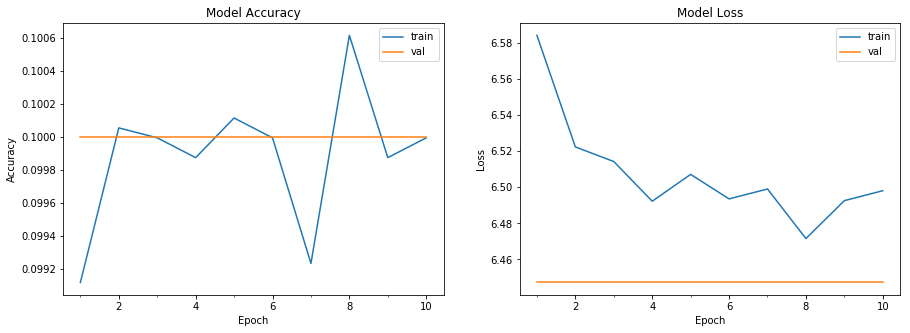

Accuracy on test data is: 10.00


In [30]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False)) # CutOut, Crop and padding
                             

start = time.time()

# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = BATCH_SIZE),
                                 samples_per_epoch = train_features.shape[0], 
                                 epochs = EPOCHS, 
                                 validation_data = (test_features, test_labels), 
                                 verbose=VERBOSE, 
                                 callbacks=[lr_manager])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))